In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
import numpy as np

In [8]:
#train data
x = np.linspace(-5, 5, 1000)[:, np.newaxis]
y = np.square(x) + np.random.normal(0, 1, x.shape)
train_x = torch.from_numpy(x).float()
train_y = torch.from_numpy(y).float()

# test data
test_x = np.linspace(-5, 5, 100)[:, np.newaxis]
test_y = np.square(test_x)  + np.random.normal(0, 1, test_x.shape)
test_x = torch.from_numpy(test_x).float()
test_y = torch.from_numpy(test_y).float()

train_dataset = Data.TensorDataset(train_x, train_y)
train_loader = Data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=2,)

In [3]:
class MyBN(nn.Module):
    def __init__(self, num_features):
        super(MyBN, self).__init__()
        self.gamma = nn.Parameter(torch.ones((num_features,)),requires_grad=True)
        self.beta = nn.Parameter(torch.zeros((num_features,)),requires_grad=True)
        self.moving_mean = torch.zeros((num_features,))
        self.moving_var = torch.zeros((num_features,))

    def forward(self, x):
        eps=1e-6
        momentum=0.5
        if self.training==False:
            x_ = (x - self.moving_mean) / torch.sqrt(self.moving_var + eps)  
        else:
            xmean = torch.mean(x,dim=0)
            xvar=torch.mean(((x-xmean)**2),dim=0)
            x_ = (x - xmean) / torch.sqrt(xvar + eps) 
            self.moving_mean = momentum * self.moving_mean + (1.0 - momentum) * xmean
            self.moving_var = momentum * self.moving_var + (1.0 - momentum) * xvar
        out = self.gamma * x_ + self.beta  
        return out


In [4]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc0=nn.Linear(1,10)
        self.bn0=MyBN(num_features=10)
        self.fc1=nn.Linear(10,10)
        self.bn1=MyBN(num_features=10)
        self.fc2=nn.Linear(10,10)
        self.bn2=MyBN(num_features=10)
        self.fc3=nn.Linear(10,10)
        self.bn3=MyBN(num_features=10)
        self.predict=nn.Linear(10,1)
    def forward(self,x):
        x = self.fc0(x)
        x = self.bn0(x)   # batch normalization
        x = torch.tanh(x)

        x = self.fc1(x)
        x = self.bn1(x)   # batch normalization
        x = torch.tanh(x)

        x = self.fc2(x)
        x = self.bn2(x)   # batch normalization
        x = torch.tanh(x)

        x = self.fc3(x)
        x = self.bn3(x)   # batch normalization
        x = torch.tanh(x)

        out=self.predict(x)
        return out


In [5]:
net=Net() 
opt=torch.optim.Adam(net.parameters(),lr=0.02)
#print(opt.param_groups) 
loss_func=nn.MSELoss()
if __name__ == "__main__":
    l=[]                                  #loss
    for epoch in range(10):
        print('Epoch: ', epoch)
        net.eval()                       #测试模式    
        pred= net(test_x)
        l.append(loss_func(pred, test_y).data.item())
        net.train()                      #训练模式
        
        for step, (b_x, b_y) in enumerate(train_loader):
            pred= net(b_x)
            loss = loss_func(pred, b_y)
            opt.zero_grad()
            loss.backward()
            opt.step()    # it will also learns the parameters in Batch Normalization
   
    print(l)

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
[139.392822265625, 93.76782989501953, 56.29964065551758, 31.076417922973633, 18.88350486755371, 15.46146011352539, 21.3355712890625, 7.81436014175415, 6.815263748168945, 4.716057300567627]


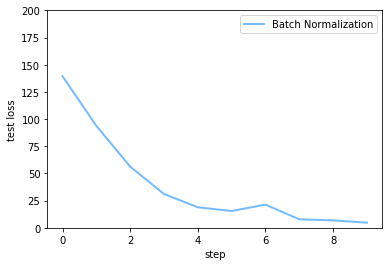

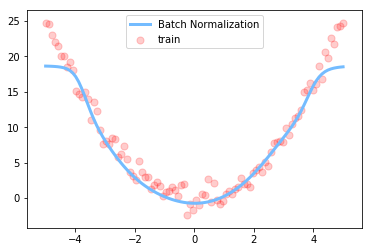

In [6]:
    #可视化loss
    plt.figure(1)
    plt.plot(l, c='#74BCFF', lw=2, label='Batch Normalization')
    plt.xlabel('step');plt.ylabel('test loss');plt.ylim((0, 200));plt.legend(loc='best')

    #测试，并且将拟合曲线展示出来
    net.eval() 
    preds = net(test_x)
    plt.figure(2)
    plt.plot(test_x.data.numpy(), preds.data.numpy(), c='#74BCFF', lw=3, label='Batch Normalization')
    plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='r', s=50, alpha=0.2, label='train')
    plt.legend(loc='best')
    plt.show()